# NBA Elite Team Analysis: Handicap Spread Coverage

## Hypothesis
> "Elite NBA teams (top 25% by win%) with good recent form cover handicapped spreads at higher rates"

## How the Handicap Works

The handicap **adjusts the closing spread in the team's favor**, making it easier to cover:

```
Example: Team has closing spread of -12 (favored by 12 points)
- Standard: Must win by 13+ to cover
- With 11-pt handicap: Effective spread becomes -1, must win by 2+ to cover
- Result: EASIER to cover, so coverage % should INCREASE with higher handicap
```

## Key Definitions
- **spread_result_difference**: How home team performed vs spread (positive = home covered)
- **Home covers with handicap H**: `spread_result_difference + H >= 0`
- **Away covers with handicap H**: `spread_result_difference <= H`
- **Elite Team**: Top 25% by win percentage
- **Recent Form**: Last 5 games average spread performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
data_file = Path().resolve().parent / 'data' / 'results' / 'nba_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NBA games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")
print(f"Columns: {list(df.columns)}")

Loaded 537 NBA games
Date range: 2025-10-21 to 2026-01-05
Columns: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']


## Step 1: Verify Handicap Logic

Let's verify our understanding with sample data before proceeding.

In [2]:
# Show sample games and verify handicap calculation
print("Sample games:")
print(df[['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']].head(5))

# Verify with first game
row = df.iloc[0]
print(f"\n--- Verification with first game ---")
print(f"Home: {row['home_team']} (spread {row['closing_spread']})")
print(f"Score: {row['home_score']} - {row['away_score']} (margin: {row['home_score'] - row['away_score']})")
print(f"spread_result_difference: {row['spread_result_difference']}")
print(f"\nHome covered standard (srd >= 0): {row['spread_result_difference'] >= 0}")
print(f"Home covered with 5pt handicap (srd + 5 >= 0): {row['spread_result_difference'] + 5 >= 0}")
print(f"Home covered with 11pt handicap (srd + 11 >= 0): {row['spread_result_difference'] + 11 >= 0}")

Sample games:
   game_date              home_team              away_team  closing_spread  \
0 2025-10-21  Oklahoma City Thunder        Houston Rockets            -6.5   
1 2025-10-21     Los Angeles Lakers  Golden State Warriors             2.5   
2 2025-10-22          Orlando Magic             Miami Heat            -8.5   
3 2025-10-22          Atlanta Hawks        Toronto Raptors            -5.5   
4 2025-10-22          Chicago Bulls        Detroit Pistons             3.5   

   home_score  away_score  spread_result_difference  
0         125         124                      -5.5  
1         109         119                      -7.5  
2         125         121                      -4.5  
3         118         138                     -25.5  
4         115         111                       7.5  

--- Verification with first game ---
Home: Oklahoma City Thunder (spread -6.5)
Score: 125 - 124 (margin: 1)
spread_result_difference: -5.5

Home covered standard (srd >= 0): False
Home covered

In [3]:
# Calculate handicap coverage for various handicap values
handicaps = [0, 3, 5, 7, 9, 11, 13, 15]

for h in handicaps:
    df[f'home_covers_{h}pt'] = (df['spread_result_difference'] + h) >= 0
    df[f'away_covers_{h}pt'] = df['spread_result_difference'] <= h

# Verify coverage increases with handicap
print("Overall coverage rates (should INCREASE with handicap):")
print("="*60)
for h in handicaps:
    home_pct = df[f'home_covers_{h}pt'].mean() * 100
    away_pct = df[f'away_covers_{h}pt'].mean() * 100
    print(f"Handicap {h:2d}pt: Home {home_pct:5.1f}%  |  Away {away_pct:5.1f}%")

Overall coverage rates (should INCREASE with handicap):
Handicap  0pt: Home  50.8%  |  Away  49.7%
Handicap  3pt: Home  58.8%  |  Away  59.0%
Handicap  5pt: Home  65.2%  |  Away  65.9%
Handicap  7pt: Home  70.2%  |  Away  69.6%
Handicap  9pt: Home  76.5%  |  Away  74.9%
Handicap 11pt: Home  80.4%  |  Away  79.5%
Handicap 13pt: Home  83.4%  |  Away  82.7%
Handicap 15pt: Home  86.0%  |  Away  86.8%


## Step 2: Calculate Team Standings & Classify Tiers

In [4]:
# Calculate team statistics
all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

team_stats = []
for team in all_teams:
    home_games = df[df['home_team'] == team]
    away_games = df[df['away_team'] == team]
    
    # Wins
    home_wins = (home_games['home_score'] > home_games['away_score']).sum()
    away_wins = (away_games['away_score'] > away_games['home_score']).sum()
    
    # Point differential
    home_diff = (home_games['home_score'] - home_games['away_score']).sum()
    away_diff = (away_games['away_score'] - away_games['home_score']).sum()
    
    total_games = len(home_games) + len(away_games)
    if total_games > 0:
        team_stats.append({
            'team': team,
            'games': total_games,
            'wins': home_wins + away_wins,
            'win_pct': (home_wins + away_wins) / total_games,
            'point_diff_avg': (home_diff + away_diff) / total_games,
            'home_games': len(home_games),
            'away_games': len(away_games)
        })

df_teams = pd.DataFrame(team_stats).sort_values('win_pct', ascending=False)

# Classify tiers
q75, q25 = df_teams['win_pct'].quantile([0.75, 0.25])
df_teams['tier'] = df_teams['win_pct'].apply(
    lambda x: 'Elite' if x >= q75 else ('Bottom' if x <= q25 else 'Mid')
)

print(f"\nTier thresholds: Elite >= {q75:.3f}, Bottom <= {q25:.3f}")
print(f"\nTier distribution:")
print(df_teams['tier'].value_counts())

print(f"\n--- ELITE TEAMS ---")
print(df_teams[df_teams['tier'] == 'Elite'][['team', 'wins', 'games', 'win_pct', 'point_diff_avg']].to_string(index=False))

Total teams: 30

Tier thresholds: Elite >= 0.646, Bottom <= 0.371

Tier distribution:
tier
Mid       13
Bottom     9
Elite      8
Name: count, dtype: int64

--- ELITE TEAMS ---
                 team  wins  games  win_pct  point_diff_avg
Oklahoma City Thunder    29     37 0.783784       11.891892
      Detroit Pistons    27     36 0.750000        6.722222
       Denver Nuggets    24     36 0.666667        6.083333
      Houston Rockets    22     33 0.666667        8.454545
   Los Angeles Lakers    22     33 0.666667        0.000000
       Boston Celtics    23     35 0.657143        7.285714
    San Antonio Spurs    24     37 0.648649        4.729730
      New York Knicks    24     37 0.648649        4.648649


## Step 3: Handicap Coverage by Tier

**Key Analysis**: Do elite teams cover at higher rates than other tiers across different handicap values?

In [5]:
# Create team-to-tier mapping
team_tier = df_teams.set_index('team')['tier'].to_dict()

# Calculate coverage by tier for each handicap
results = []
for h in handicaps:
    for tier in ['Elite', 'Mid', 'Bottom']:
        tier_teams = df_teams[df_teams['tier'] == tier]['team'].tolist()
        
        total_games = 0
        total_covers = 0
        
        for team in tier_teams:
            # Home games
            hg = df[df['home_team'] == team]
            total_games += len(hg)
            total_covers += ((hg['spread_result_difference'] + h) >= 0).sum()
            
            # Away games
            ag = df[df['away_team'] == team]
            total_games += len(ag)
            total_covers += (ag['spread_result_difference'] <= h).sum()
        
        results.append({
            'handicap': h,
            'tier': tier,
            'games': total_games,
            'covers': total_covers,
            'cover_pct': total_covers / total_games if total_games > 0 else 0
        })

df_results = pd.DataFrame(results)

# Display pivot table
pivot = df_results.pivot(index='handicap', columns='tier', values='cover_pct')[['Elite', 'Mid', 'Bottom']]
print("Coverage % by Handicap and Tier:")
print("(Higher handicap = easier to cover = higher %)")
print("="*50)
print((pivot * 100).round(1))

Coverage % by Handicap and Tier:
(Higher handicap = easier to cover = higher %)
tier      Elite   Mid  Bottom
handicap                     
0          55.3  49.2    47.5
3          62.3  58.7    56.3
5          69.7  65.3    62.3
7          74.6  69.3    66.7
9          80.3  75.2    72.3
11         83.1  79.0    78.6
13         85.6  82.2    82.1
15         88.4  86.7    84.3


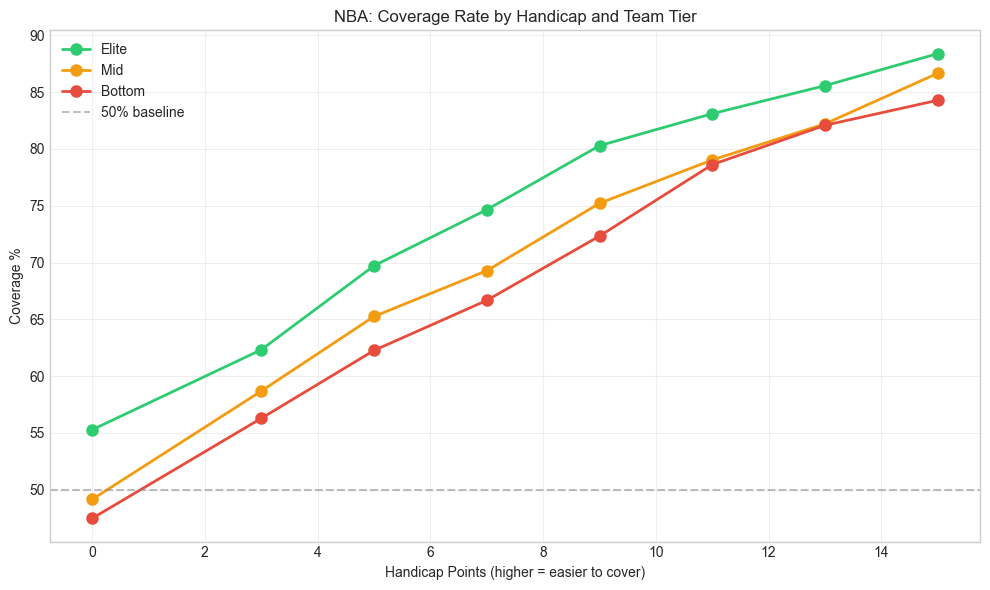

In [6]:
# Visualize
plt.figure(figsize=(10, 6))
colors = {'Elite': '#2ecc71', 'Mid': '#f39c12', 'Bottom': '#e74c3c'}

for tier in ['Elite', 'Mid', 'Bottom']:
    data = df_results[df_results['tier'] == tier]
    plt.plot(data['handicap'], data['cover_pct'] * 100, 
             marker='o', label=tier, color=colors[tier], linewidth=2, markersize=8)

plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
plt.xlabel('Handicap Points (higher = easier to cover)')
plt.ylabel('Coverage %')
plt.title('NBA: Coverage Rate by Handicap and Team Tier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 4: Recent Form Analysis

Does recent performance (last 5 games) predict coverage?

In [7]:
# Calculate recent form for each team's games
df_sorted = df.sort_values('game_date')

form_data = []
for team in all_teams:
    games = []
    for _, row in df_sorted.iterrows():
        if row['home_team'] == team:
            games.append({'srd': row['spread_result_difference'], 'is_home': True, 'date': row['game_date']})
        elif row['away_team'] == team:
            games.append({'srd': -row['spread_result_difference'], 'is_home': False, 'date': row['game_date']})
    
    if len(games) >= 6:
        tg = pd.DataFrame(games)
        tg['last_5_avg'] = tg['srd'].rolling(5).mean().shift(1)
        tier = team_tier.get(team, 'Unknown')
        
        for _, r in tg.dropna().iterrows():
            # Calculate if this team covered with 11pt handicap in this game
            if r['is_home']:
                covers_11pt = r['srd'] + 11 >= 0  # For home, srd is already correct
            else:
                covers_11pt = -r['srd'] <= 11  # For away, we stored -srd, so flip back
            
            form_data.append({
                'team': team,
                'tier': tier,
                'last_5_avg': r['last_5_avg'],
                'covers_11pt': covers_11pt,
                'is_home': r['is_home']
            })

df_form = pd.DataFrame(form_data)
print(f"Games with recent form data: {len(df_form)}")

# Correlation
corr = df_form['last_5_avg'].corr(df_form['covers_11pt'].astype(int))
print(f"Correlation (last 5 avg vs 11pt coverage): {corr:.3f}")

Games with recent form data: 924
Correlation (last 5 avg vs 11pt coverage): 0.024


In [8]:
# Group by form buckets
df_form['form_bucket'] = pd.cut(
    df_form['last_5_avg'], 
    bins=[-50, -5, 0, 5, 50],
    labels=['Poor (<-5)', 'Below Avg (-5 to 0)', 'Above Avg (0 to 5)', 'Good (>5)']
)

form_analysis = df_form.groupby('form_bucket', observed=True).agg(
    games=('covers_11pt', 'count'),
    covers=('covers_11pt', 'sum'),
    cover_pct=('covers_11pt', 'mean')
).round(3)

print("11-Point Handicap Coverage by Recent Form:")
print(form_analysis)

11-Point Handicap Coverage by Recent Form:
                     games  covers  cover_pct
form_bucket                                  
Poor (<-5)             193     150      0.777
Below Avg (-5 to 0)    281     220      0.783
Above Avg (0 to 5)     242     198      0.818
Good (>5)              208     170      0.817


## Step 5: Combined Analysis - Elite Teams + Good Form

In [9]:
# Define "good form" as last 5 avg > 3
df_form['good_form'] = df_form['last_5_avg'] > 3

combined = df_form.groupby(['tier', 'good_form']).agg(
    games=('covers_11pt', 'count'),
    covers=('covers_11pt', 'sum'),
    cover_pct=('covers_11pt', 'mean')
).round(3)

print("11-Point Handicap Coverage by Tier + Form:")
print(combined)

# Elite team breakdown
elite_data = df_form[df_form['tier'] == 'Elite']
elite_good = elite_data[elite_data['good_form']]
elite_bad = elite_data[~elite_data['good_form']]

print(f"\n--- ELITE TEAMS ---")
print(f"Good Form: {elite_good['covers_11pt'].mean()*100:.1f}% ({len(elite_good)} games)")
print(f"Poor Form: {elite_bad['covers_11pt'].mean()*100:.1f}% ({len(elite_bad)} games)")

11-Point Handicap Coverage by Tier + Form:
                  games  covers  cover_pct
tier   good_form                          
Bottom False        196     153      0.781
       True          77      66      0.857
Elite  False        142     120      0.845
       True         102      80      0.784
Mid    False        289     221      0.765
       True         118      98      0.831

--- ELITE TEAMS ---
Good Form: 78.4% (102 games)
Poor Form: 84.5% (142 games)


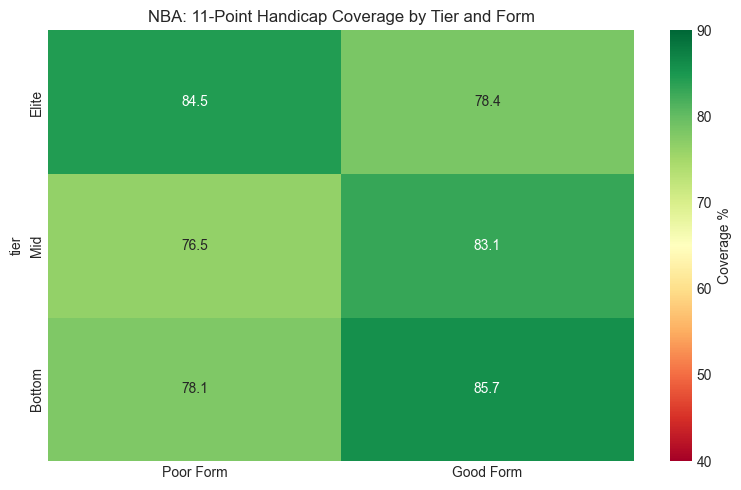

In [10]:
# Heatmap
pivot_heat = df_form.pivot_table(
    index='tier', columns='good_form', values='covers_11pt', aggfunc='mean'
).reindex(['Elite', 'Mid', 'Bottom'])
pivot_heat.columns = ['Poor Form', 'Good Form']

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_heat * 100, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Coverage %'}, vmin=40, vmax=90)
plt.title('NBA: 11-Point Handicap Coverage by Tier and Form')
plt.tight_layout()
plt.show()

## Step 6: Statistical Significance

In [11]:
# Chi-square: Tier vs Coverage
ct_tier = pd.crosstab(df_form['tier'], df_form['covers_11pt'])
chi2_tier, p_tier, _, _ = stats.chi2_contingency(ct_tier)

print("Chi-Square Test: Tier vs 11pt Coverage")
print(f"  Chi-square: {chi2_tier:.3f}, p-value: {p_tier:.4f}")
print(f"  Significant (p<0.05): {'YES' if p_tier < 0.05 else 'NO'}")

# Chi-square: Form vs Coverage
ct_form = pd.crosstab(df_form['good_form'], df_form['covers_11pt'])
chi2_form, p_form, _, _ = stats.chi2_contingency(ct_form)

print(f"\nChi-Square Test: Good Form vs 11pt Coverage")
print(f"  Chi-square: {chi2_form:.3f}, p-value: {p_form:.4f}")
print(f"  Significant (p<0.05): {'YES' if p_form < 0.05 else 'NO'}")

Chi-Square Test: Tier vs 11pt Coverage
  Chi-square: 1.252, p-value: 0.5349
  Significant (p<0.05): NO

Chi-Square Test: Good Form vs 11pt Coverage
  Chi-square: 1.219, p-value: 0.2695
  Significant (p<0.05): NO


## Summary

In [12]:
print("="*70)
print("NBA ELITE TEAM ANALYSIS: SUMMARY")
print("="*70)

print(f"\nData: {len(df)} games, {len(all_teams)} teams")
print(f"Elite teams: {len(df_teams[df_teams['tier'] == 'Elite'])}")

print(f"\nCoverage by Tier (11pt handicap):")
for tier in ['Elite', 'Mid', 'Bottom']:
    pct = df_form[df_form['tier'] == tier]['covers_11pt'].mean() * 100
    print(f"  {tier}: {pct:.1f}%")

print(f"\nElite Teams by Form (11pt handicap):")
print(f"  Good Form: {elite_good['covers_11pt'].mean()*100:.1f}%")
print(f"  Poor Form: {elite_bad['covers_11pt'].mean()*100:.1f}%")

print(f"\nStatistical Significance:")
print(f"  Tier effect: p={p_tier:.4f} ({'Significant' if p_tier < 0.05 else 'Not significant'})")
print(f"  Form effect: p={p_form:.4f} ({'Significant' if p_form < 0.05 else 'Not significant'})")

NBA ELITE TEAM ANALYSIS: SUMMARY

Data: 537 games, 30 teams
Elite teams: 8

Coverage by Tier (11pt handicap):
  Elite: 82.0%
  Mid: 78.4%
  Bottom: 80.2%

Elite Teams by Form (11pt handicap):
  Good Form: 78.4%
  Poor Form: 84.5%

Statistical Significance:
  Tier effect: p=0.5349 (Not significant)
  Form effect: p=0.2695 (Not significant)
